In [29]:
import os
import sys
import random

import yaml
import numpy as np
import nibabel as nib

sys.path.append(os.path.join('..', '..', 'tta_uia_segmentation', 'src'))

from dataset.dataset_in_memory import get_datasets


In [35]:
dataset     = 'vu'
seed        = 123
params_fp   = '/scratch_net/biwidl319/jbermeo/logs/wmh/ddpm/normalized_imgs/no_bg_supp_3x3_conv/3_19/batch_size_128_cond_by_concat_multi_gpu/params.yaml'
output_dir  = f'/scratch_net/biwidl319/jbermeo/data/wmh_miccai/{dataset}/original_vols_as_nifti_files'

np.random.seed(seed)
random.seed(seed)

run_params = yaml.safe_load(open(params_fp, 'r'))
dataset_params = run_params['dataset'][dataset]
train_ddpm_cfg = run_params['training']['ddpm']
model_ddpm_cfg = run_params['model']['ddpm_unet']


n_classes = dataset_params['n_classes']

In [36]:
train_ddpm_cfg['use_original_imgs']

False

In [37]:
(ds_train, ds_val, ds_test) = get_datasets(
        splits          = ['train', 'val', 'test'],
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        image_size      = (48, 256, 256),
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        bg_suppression_opts = None
    )

In [38]:
ds_dict = {
    'train': ds_train,
    'val': ds_val,
    'test': ds_test
}

In [39]:
for ds_name, ds in ds_dict.items():
    out_dir = os.path.join(output_dir, ds_name)
    os.makedirs(out_dir, exist_ok=True)
    
    out_dir_imgs = os.path.join(out_dir, 'imgs')
    os.makedirs(out_dir_imgs, exist_ok=True)
    
    out_dir_labels = os.path.join(out_dir, 'labels')
    os.makedirs(out_dir_labels, exist_ok=True)
    
    for i in range(len(ds)):
        shape = ds.get_original_images(i)[0].shape
        if shape[-2] != 240 or shape[-1] != 240:
            print(i, shape)
        
        original_pix_size = ds.pix_size_original[:, i] # px, py, pz
        
        img, label, _ = ds.get_original_images(i, as_onehot=False)
        img = img.permute(0, 2, 3, 1).squeeze().numpy()
        label = label.permute(0, 2, 3, 1).squeeze().numpy()
        
        # save image as nifti fil
        affine = np.eye(4)
        affine[0,0] = original_pix_size[0]
        affine[1,1] = original_pix_size[1]
        affine[2,2] = original_pix_size[2]
        affine[1,:] = affine[1,:] * -1  # Flip y-axis
        img_nii = nib.Nifti1Image(img, affine)
        img_nii.header.set_zooms(original_pix_size)
        nib.save(img_nii, os.path.join(out_dir_imgs, f'vol_{i}.nii.gz'))
        
        # save label as nifti file
        label_nii = nib.Nifti1Image(label, np.eye(4))
        label_nii.header.set_zooms(original_pix_size)
        nib.save(label_nii, os.path.join(out_dir_labels, f'vol_{i}_label.nii.gz'))
    

0 torch.Size([1, 83, 132, 256])
1 torch.Size([1, 83, 132, 256])
2 torch.Size([1, 83, 132, 256])
3 torch.Size([1, 83, 132, 256])
4 torch.Size([1, 83, 132, 256])
5 torch.Size([1, 83, 132, 256])
6 torch.Size([1, 83, 132, 256])
7 torch.Size([1, 83, 132, 256])
8 torch.Size([1, 83, 132, 256])
9 torch.Size([1, 83, 132, 256])
0 torch.Size([1, 83, 132, 256])
1 torch.Size([1, 83, 132, 256])
2 torch.Size([1, 83, 132, 256])
3 torch.Size([1, 83, 132, 256])
4 torch.Size([1, 83, 132, 256])
0 torch.Size([1, 83, 132, 256])
1 torch.Size([1, 83, 132, 256])
2 torch.Size([1, 83, 132, 256])
3 torch.Size([1, 83, 132, 256])
4 torch.Size([1, 83, 132, 256])


In [30]:
img_nii.header['pixdim'][4:] = 0

In [32]:
img_nii.header['pixdim']

array([-1.        ,  0.9583333 ,  0.95833325,  2.9999993 ,  0.        ,
        0.        ,  0.        ,  0.        ], dtype=float32)

array([[  -0.95833331,    0.        ,    0.        ,  114.52083096],
       [   0.        ,    0.95833325,    0.        , -114.52082384],
       [   0.        ,    0.        ,    2.99999928,  -70.49998319],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [34]:
nib.save(img_nii, 'ex_4.nii.gz')

In [35]:
c = nib.load('ex_4.nii.gz')

In [36]:
c.header['pixdim'][1:4]

array([0.9583333 , 0.95833325, 2.9999993 ], dtype=float32)

In [43]:
c.header['pixdim'][1:4]

array([0.9583333 , 0.95833325, 2.9999993 ], dtype=float32)

In [42]:
c.affine

array([[ 1.,  0.,  0.,  0.],
       [-0., -1., -0., -0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [66]:
aff = np.array(img_nii.affine)
np.sqrt(np.sum(aff * aff, axis=0))[:-1]

array([0.95833331, 0.95833325, 2.99999928])

In [49]:
b.header['pixdim'][1:4]

array([0.9583333 , 0.95833325, 2.9999993 ], dtype=float32)

In [39]:
print(b.affine)

[[-9.55749035e-01 -4.81770411e-02  1.60402849e-01  1.18610664e+02]
 [ 2.20411010e-02 -8.68188620e-01 -1.26836812e+00  1.27181854e+02]
 [ 6.67887405e-02 -4.02902126e-01  2.71394706e+00  1.33168182e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [53]:
aff = np.array(b.affine)
np.sqrt(np.sum(aff * aff, axis=0))[:-1]

array([0.95833333, 0.95833326, 2.99999923])

In [50]:
nib.save(nib.Nifti1Image(img_nii.get_fdata(), header=img_nii.header, affine=b.affine), 'ex_5.nii.gz')

In [52]:
print(b.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.9583333  0.95833325 2.9999993  0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.031557195
quatern_c       : -0.21605442
quatern_d       : 0.9756906
qoffset_x       : 118.610664
qoffset_y   

In [12]:
nib.save(img_nii, 'ex_2.nii.gz')

In [13]:
print(img_nii.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 240 240  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.          0.9583333   0.95833325  2.9999993   1.          1.
  1.          1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 1.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : -0.0
qoffset_z  

In [14]:
a = nib.load('/scratch_net/biwidl319/jbermeo/data/wmh_miccai/umc/original_vols_as_nifti_files/train/imgs/vol_0.nii.gz')

In [13]:
print(a.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 240 240  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.9583333  0.95833325 2.9999993  1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.

In [19]:
b = nib.load('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/notebooks/Synthseg/FLAIR.nii.gz')

In [16]:
print(b.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.9583333  0.95833325 2.9999993  0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.031557195
quatern_c       : -0.21605442
quatern_d       : 0.9756906
qoffset_x       : 118.610664
qoffset_y   

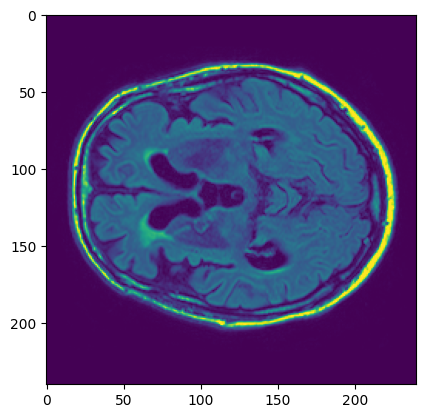

In [21]:
import matplotlib.pyplot as plt
plt.imshow(a.get_fdata()[:, :, 20])


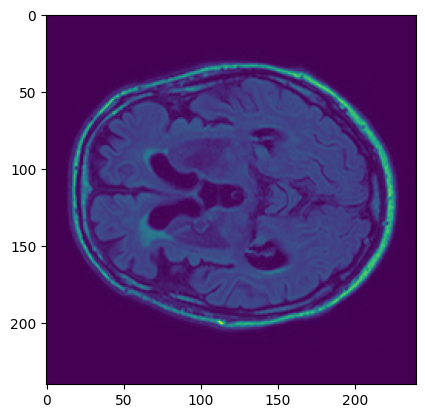

In [20]:
plt.imshow(b.get_fdata()[:, :, 20])


In [19]:
b.get_fdata().max()


2380.619140625

In [40]:

from torchmetrics.functional.classification import dice

In [41]:
import torch

In [49]:

seg_1 = torch.tensor(nib.load('FLAIR_synthseg.nii.gz').get_fdata())
seg_2 = torch.tensor(nib.load('T1_synthseg.nii.gz').get_fdata())
seg_3 = torch.tensor(nib.load('ex_5_synthseg.nii.gz').get_fdata())
seg_4 = torch.tensor(nib.load('vol_0_synthseg.nii.gz').get_fdata())

In [50]:
dice(seg_3.type(torch.uint8), seg_2.type(torch.uint8), num_classes=61, ignore_index=0)#, num_classes=4, reduction='none')

tensor(0.7994)

In [51]:
dice(seg_4.type(torch.uint8), seg_2.type(torch.uint8), num_classes=61, ignore_index=0)#, num_classes=4, reduction='none')

tensor(0.0542)

In [42]:
max(torch.unique(seg_1))

tensor(60., dtype=torch.float64)